In [1]:
# downgrading numpy for Tensorflow compatibilty
!pip install --upgrade numpy==1.19.5

In [2]:
!pip install pydot

In [3]:
!pip install pydotplus

In [4]:
!pip install graphviz

In [57]:
import pathlib
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from scipy import stats
from sklearn.preprocessing import MinMaxScaler, RobustScaler, PolynomialFeatures, LabelEncoder, OneHotEncoder
from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.impute import SimpleImputer

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Activation, Dropout, Flatten
from keras.wrappers.scikit_learn import KerasRegressor
from tensorflow.keras.layers.experimental import preprocessing
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

import pydot
import pydotplus
import graphviz

In [ ]:
print(np.__version__)

FUNCTIONS AND COMMONLY USED CONSTANTS

In [ ]:
class MultiColumnLabelEncoder:
    def __init__(self,columns = None):
        self.columns = columns # array of column names to encode

    def fit(self,X,y=None):
        return self # not relevant here

    def transform(self,X):
        '''
        Transforms columns of X specified in self.columns using
        LabelEncoder(). If no columns specified, transforms all
        columns in X.
        '''
        output = X.copy()
        if self.columns is not None:
            for col in self.columns:
                output[col] = LabelEncoder().fit_transform(output[col])
        else:
            for colname,col in output.iteritems():
                output[colname] = LabelEncoder().fit_transform(col)
        return output

    def fit_transform(self,X,y=None):
        return self.fit(X,y).transform(X)
    
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.xlabel('Epoch')
  plt.ylabel('Error [C6H6(GT)]')
  plt.legend()
  plt.grid(True)
    
def plot_accuracy(history):
  plt.plot(history.history['accuracy'], label='accuracy')
  plt.plot(history.history['val_accuracy'], label='val_accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.grid(True)

**1. REGRESSION**

*Reminder*:
- `C6H6(GT)` is the target 

In [ ]:
df_reg = pd.read_csv(r'C:\Users\1\Desktop\HW\AirQualityUCI.csv', sep=';', na_values=-200, decimal = ',')

# drop empty columns and rows 
df_reg = df_reg.drop(columns=['Unnamed: 15', 'Unnamed: 16'])
df_reg = df_reg.drop(df_reg.tail(114).index)

In [ ]:
df_reg.head(10)

Feature engineering:

In [ ]:
# hour is the only info in Time column
df_reg['hour'] = pd.to_numeric(df_reg['Time'].astype(str).str[0:2])
df_reg.hour.unique()

In [ ]:
# cyclical hour feature
df_reg['hour_sin'] = np.sin(df_reg.hour*(2.*np.pi/24))
df_reg['hour_cos'] = np.cos(df_reg.hour*(2.*np.pi/24))

In [ ]:
# extract info from Date column
df_reg['Day'] = pd.to_numeric(df_reg['Date'].astype(str).str[0:2])
df_reg['Month'] = pd.to_numeric(df_reg['Date'].astype(str).str[3:5])
df_reg['Year'] = pd.to_numeric(df_reg['Date'].astype(str).str[6::])

In [ ]:
# cyclical month feature
df_reg['month_sin'] = np.sin((df_reg.Month-1)*(2.*np.pi/12))
df_reg['month_cos'] = np.cos((df_reg.Month-1)*(2.*np.pi/12))

In [ ]:
# set Date as index 
df_reg.Time = df_reg.Time.str.replace('.',':')
df_reg.Date = df_reg["Date"]+' '+df_reg['Time']
df_reg.Date = pd.to_datetime(df_reg.Date)
df_reg = df_reg.set_index('Date')
df_reg.drop(['Time'], axis = 1, inplace = True)

In [ ]:
df_reg.info()

Data preparation.

In [ ]:
# missing values % across columns
total = df_reg.isna().sum().sort_values(ascending=False)
percent = (df_reg.isna().sum()/df_reg.isna().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

In [ ]:
# remove 90% empty column
df_reg = df_reg.drop(['NMHC(GT)'], axis=1)

In [ ]:
# remove rows with >10 empty values 
bad_rows = df_reg[df_reg.shape[1] - df_reg.count(axis=1) > 10].index
df_reg.drop(bad_rows, axis = 0, inplace = True)

In [ ]:
# remove all rows with missing target
df_reg.drop(df_reg[df_reg['C6H6(GT)'].isnull()].index, axis = 0, inplace = True)

In [ ]:
# final NAs check
df_reg.isna().sum()

We still have NA values to fill in the features:
- `CO(GT)`
- `NOx(GT)`
- `NO2(GT)`

Train / test split to prevent info spills

In [ ]:
# train = first 70%, test = last 30%  
df_reg = df_reg.sort_index()
train_reg, test_reg = df_reg.iloc[:7000,:], df_reg.iloc[2000:,:]

In [ ]:
train_reg.hist(figsize=(12, 15), bins=20, xlabelsize=8, ylabelsize=8);

In [ ]:
# filling NAs with medians since the 3 features are skewed
to_fill = {}
for i in train_reg.columns:
    to_fill[i] = np.nanmedian(train_reg[i])
train_reg = train_reg.fillna(value = to_fill)

In [ ]:
# same for the test set
test_reg = test_reg.fillna(value = to_fill)

In [ ]:
# the data needs to be scaled
train_reg.boxplot(rot = 45);

In [ ]:
# the target is skewed
ax = sns.histplot(train_reg['C6H6(GT)'], kde=True)
ax.set_title('Target variable C6H6(GT)');

In [ ]:
# applying power transformation
target_tr, lmbda = stats.yeojohnson(train_reg['C6H6(GT)'])

ax = sns.histplot((target_tr), kde=True)
ax.set_title('Target variable C6H6(GT)');

In [ ]:
# transforming the test target
target_test_tr, lmbda = stats.yeojohnson(test_reg['C6H6(GT)'])

In [ ]:
# separate X and the target 
X_train_reg, y_train_reg = train_reg.drop('C6H6(GT)', axis = 1), train_reg['C6H6(GT)']
X_test_reg, y_test_reg = test_reg.drop('C6H6(GT)', axis = 1), test_reg['C6H6(GT)']

Taking the best-performing transformations from the Linear Regression homework:

In [ ]:
# MinMax scaling
X_train_reg_minmax = pd.DataFrame(MinMaxScaler().fit_transform(X_train_reg), columns = X_train_reg.columns)
minmax_scaler = MinMaxScaler().fit(X_train_reg)

In [ ]:
# scaling the test features
X_test_reg_minmax = pd.DataFrame(minmax_scaler.transform(X_test_reg), columns = X_test_reg.columns)

In [ ]:
# creating polynomial X^2 features 
poly = PolynomialFeatures(2).fit(X_train_reg_minmax)

X_train_reg_poly = pd.DataFrame(poly.transform(X_train_reg_minmax))
X_test_reg_poly = pd.DataFrame(poly.transform(X_test_reg_minmax))

Neural Network Keras model

In [ ]:
# building a simple NN with 1 layer
linear_model = tf.keras.Sequential([
    layers.Dense(units=1)
])

In [ ]:
# configuring the training procedure 
# loss = MSE 
linear_model.compile(
    optimizer = tf.optimizers.Adam(learning_rate=0.1),
    loss='mean_squared_error')

In [ ]:
# executing training on the train data 
history_lin = linear_model.fit(
    X_train_reg_minmax, y_train_reg,
    epochs=100,
    verbose=0,
    validation_split = 0.2)

In [ ]:
plot_loss(history_lin)

Seems like the simple model does not perform well. Let's try polynomial features.

In [ ]:
# building and executing polynomial model
polynomial_model = tf.keras.Sequential([
    layers.Dense(units=1)
])

polynomial_model.compile(
    optimizer = tf.optimizers.Adam(learning_rate=0.1),
    loss='mean_squared_error')

history_poly = polynomial_model.fit(
    X_train_reg_poly, y_train_reg,
    epochs=100,
    verbose=0,
    validation_split = 0.2)

In [ ]:
plot_loss(history_poly)

In [ ]:
# creating test results DF for models comparison
test_results_reg = {}

In [ ]:
# saving linear model MSE
test_results_reg['linear_model'] = linear_model.evaluate(
    X_test_reg_minmax, y_test_reg, verbose=0)

In [ ]:
# saving polynomial model MSE
test_results_reg['polynomial_model'] = polynomial_model.evaluate(
    X_test_reg_poly, y_test_reg, verbose=0)

In [ ]:
pd.DataFrame(test_results_reg, index=['Mean squared error [C6H6(GT)]']).T

The score of the polynomial_model is comparable with the MSE of **0.031496** yielded by the best-performing linear model. 

In [ ]:
# visualising predictions
test_predictions_reg = polynomial_model.predict(X_test_reg_poly).flatten()

a = plt.axes(aspect='equal')
plt.scatter(y_test_reg, test_predictions_reg)
plt.xlabel('True Values [C6H6(GT)]')
plt.ylabel('Predictions [C6H6(GT)]')
lims = [-5, 70]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

**2. CLASSIFICATION**

In [ ]:
# read the classification dataset
df_clf = pd.read_csv(r'C:\Users\1\Desktop\HW\dataset_57_hypothyroid.csv', na_values = '?')
df_clf.head()

In [ ]:
# dropping features that don't bring useful information
df_clf.drop(['TBG','TBG_measured','TSH_measured', 'T3_measured', \
           'TT4_measured', 'T4U_measured', 'FTI_measured', 'TBG_measured', \
           'hypopituitary'], axis = 1, inplace = True)

In [ ]:
# numerical and categorical grouping
cat_vals = [i for i in df_clf.columns if df_clf.dtypes[i] == 'O']
num_vals = [i for i in df_clf.columns if df_clf.dtypes[i] == 'float64']
cat_vals.remove('Class')

In [ ]:
# dropping the age outlier
df_clf.drop(df_clf[df_clf.age > 100].index, inplace = True)

In [ ]:
# dropping 2 secondary_hypothyroid cases
df_clf.drop(df_clf[df_clf.Class == 'secondary_hypothyroid'].index, inplace = True)

In [ ]:
# train / test split
X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(
    df_clf.drop('Class',axis=1), df_clf.Class, test_size=0.2, stratify = df_clf.Class)

In [ ]:
# filling NAs: numerical features 
num_imputer = SimpleImputer(strategy='median')
# train
X_train_clf[num_vals] = num_imputer.fit_transform(X_train_clf[num_vals])

# test
X_test_clf[num_vals] = num_imputer.transform(X_test_clf[num_vals])

In [ ]:
# filling NAs: categorical features 
cat_imputer = SimpleImputer(strategy='constant', fill_value='unknown')

# train
X_train_clf.sex = cat_imputer.fit_transform(X_train_clf.sex.values.reshape(-1, 1))

# test
X_test_clf.sex = cat_imputer.transform(X_test_clf.sex.values.reshape(-1, 1))

In [ ]:
# scaling 
vals_to_scale = [x for x in num_vals if x!='TSH']
robust_scaler = RobustScaler()

# train
X_train_clf[vals_to_scale] = robust_scaler.fit_transform(X_train_clf[vals_to_scale])
X_train_clf.TSH = np.log(X_train_clf.TSH)

# test
X_test_clf[vals_to_scale] = robust_scaler.transform(X_test_clf[vals_to_scale])
X_test_clf.TSH = np.log(X_test_clf.TSH)

In [ ]:
# columns for label encoding 
labelencvars = cat_vals.copy()
labelencvars.remove('sex')
labelencvars.remove('referral_source')

In [ ]:
# label encoding 
le = LabelEncoder()
# train
X_train_clf[labelencvars] = X_train_clf[labelencvars].apply(le.fit_transform)

# test
X_test_clf[labelencvars] = X_test_clf[labelencvars].apply(le.transform)

In [ ]:
# one-hot encoding categorical features
for i in ['sex', 'referral_source']:
    cols_train = pd.get_dummies(X_train_clf[i], prefix = i)
    cols_test = pd.get_dummies(X_test_clf[i], prefix = i)
    X_train_clf.drop(i, axis = 1, inplace=True)
    X_test_clf.drop(i, axis = 1, inplace=True)
    X_train_clf = pd.concat([X_train_clf,cols_train], axis = 1)
    X_test_clf = pd.concat([X_test_clf,cols_test], axis = 1)

In [ ]:
# one-hot encoding the target
y_cols_train = pd.get_dummies(y_train_clf, prefix = 'y_')
y_cols_test = pd.get_dummies(y_test_clf, prefix = 'y_')

In [ ]:
# checking the number of features 
X_train_clf.shape

In [ ]:
# building a NN model with 
# a single layer and
# number of neurons as the number of features / 2 
clf_model = tf.keras.Sequential([
    tf.keras.layers.Dense(13, input_dim=27, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])

In [ ]:
# compiling the model
# we're interested in recall metric (don't want to miss a positive case)
clf_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
# executing model training
history_clf = clf_model.fit(
    X_train_clf, y_cols_train,
    epochs=100,
    verbose=0,
    validation_split = 0.2)

In [ ]:
plot_accuracy(history_clf)

In [ ]:
test_results_clf = clf_model.evaluate(
    X_test_clf, y_cols_test, verbose=0)
print(test_results_clf)

The accuracy score is comparible with the score of **0.97** yeilded by the logistic regression with regularization.

**3. COMPUTER VISION**

In [11]:
train_path = (r"C:\Users\1\Desktop\HW\hotdog__not_hotdog\train")
test_path = (r"C:\Users\1\Desktop\HW\hotdog__not_hotdog\test")

In [12]:
# check for corrupted images
num_skipped = 0
for folder_name in ("hot_dog", "not_hot_dog"):
    folder_path = os.path.join(r"C:\Users\1\Desktop\HW\hotdog__not_hotdog\train", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            os.remove(fpath)

print("Deleted %d images" % num_skipped)

Deleted 0 images


In [76]:
# artificially increasing images variability
# data generator augments the original sample on-the-go (realtime augmentation)

train_datagen = ImageDataGenerator(
        rotation_range=45,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest',
        validation_split=0.2)

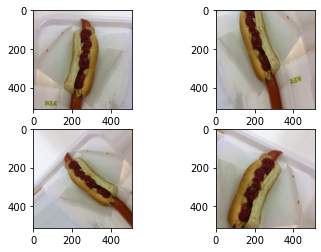

In [68]:
# checking an augmented sample example

# loading a random image
img_path = r'C:\Users\1\Desktop\HW\hotdog__not_hotdog\train\hot_dog\856178.jpg'
img = image.load_img(img_path)

# saving distorted images
images = [img]
img_arr = image.img_to_array(img)
img_arr = img_arr.reshape((1,) + img_arr.shape)
for batch in datagen.flow(img_arr, batch_size=1):
    images.append(image.array_to_img(batch[0]) )
    if len(images) >= 4:
        break
        
# displaying the augmented sample    
f, xyarr = plt.subplots(2,2)
xyarr[0,0].imshow(images[0])
xyarr[0,1].imshow(images[1])
xyarr[1,0].imshow(images[2])
xyarr[1,1].imshow(images[3])
plt.show()

In [77]:
# building a model

CV_model = Sequential()
CV_model.add(Conv2D(32, (3, 3), input_shape=(180, 180, 3)))
CV_model.add(Activation('relu'))
CV_model.add(MaxPooling2D(pool_size=(2, 2)))

CV_model.add(Conv2D(32, (3, 3)))
CV_model.add(Activation('relu'))
CV_model.add(MaxPooling2D(pool_size=(2, 2)))

CV_model.add(Conv2D(64, (3, 3)))
CV_model.add(Activation('relu'))
CV_model.add(MaxPooling2D(pool_size=(2, 2)))

CV_model.add(Flatten())  
CV_model.add(Dense(64))
CV_model.add(Activation('relu'))
CV_model.add(Dropout(0.5))
CV_model.add(Dense(1))
CV_model.add(Activation('sigmoid'))

In [94]:
# compiling the model

CV_model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [89]:
# preparing the data 

batch_size = 16

# test images will not be distorted
test_datagen = ImageDataGenerator(rescale=1./255)

# specifying train generator
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(180, 180),
    batch_size=batch_size,
    class_mode='binary',
    subset='training')

# specifying validation generator
validation_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(180, 180),
    batch_size=batch_size,
    class_mode='binary',
    subset='validation')

Found 400 images belonging to 2 classes.
Found 98 images belonging to 2 classes.


In [95]:
# training the model
CV_model.fit_generator(
        train_generator,
        steps_per_epoch= 400/batch_size,
        epochs=50,
        validation_data=validation_generator,
        validation_steps= 98/batch_size)

CV_model.save_weights('first_try.h5')

Epoch 1/50
25/25 [==============================] - 25s 1s/step - loss: 0.6933 - accuracy: 0.4600 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 2/50
25/25 [==============================] - 24s 950ms/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 3/50


KeyboardInterrupt: 

The accuracy score is no better than a random guess. Several optimizers have been used as well as different batch sizes.  